In [47]:
from main import *
from models import *
from hyperparameter import *

# Preprocessing, Visualization, and Train/Val/Test Split

In [2]:
data_dir ='data' # Change to the path to your directory
train_images_dir = os.path.join(data_dir, 'Training')
test_images_dir = os.path.join(data_dir, 'Testing')
print(f"Data directory: {data_dir}")
print(f"Training directory: {train_images_dir}")
print(f"Testing directory: {test_images_dir}")

Data directory: data
Training directory: data/Training
Testing directory: data/Testing


In [3]:
# Load the training and test data
try:
    train_data, test_data = get_images(train_images_dir, test_images_dir)
    print("Data loading completed successfully.")
    print(f"Number of training samples: {train_data.samples}")
    print(f"Number of test samples: {test_data.samples}")
    print(f"Class names: {train_data.class_indices}")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Data loading completed successfully.
Number of training samples: 5712
Number of test samples: 1311
Class names: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [4]:
class_names_train = list(train_data.class_indices.keys())
class_names_test = list(test_data.class_indices.keys())
print(class_names_train)

['glioma', 'meningioma', 'notumor', 'pituitary']


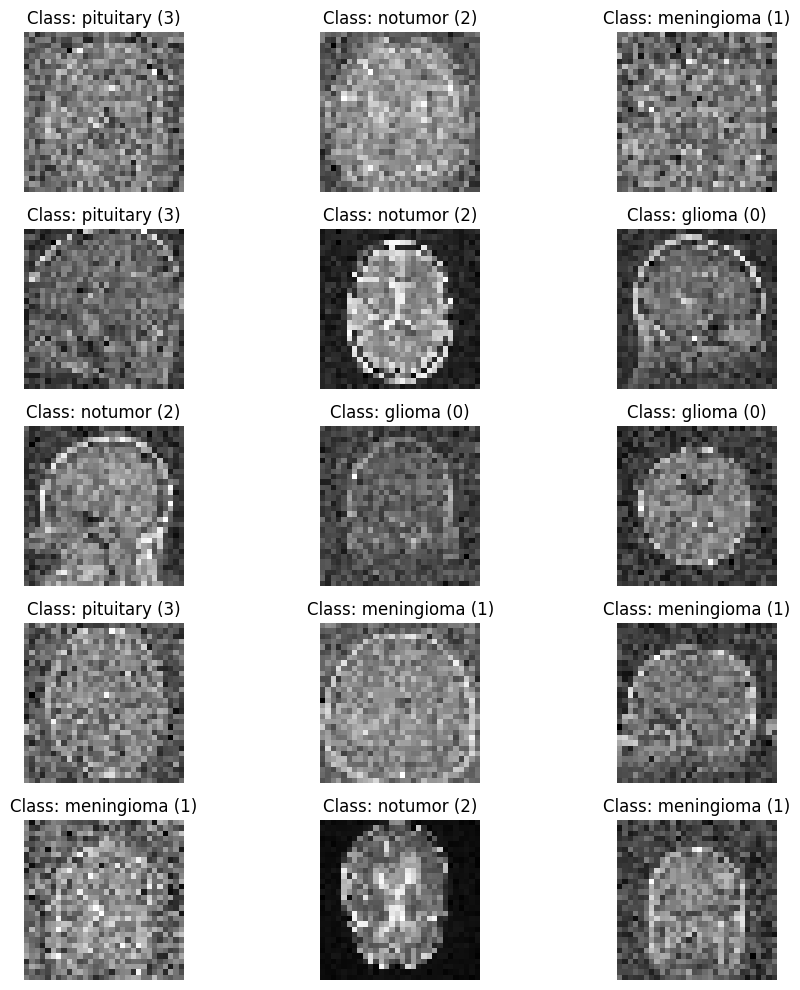

In [5]:
visualize_batch(train_data)

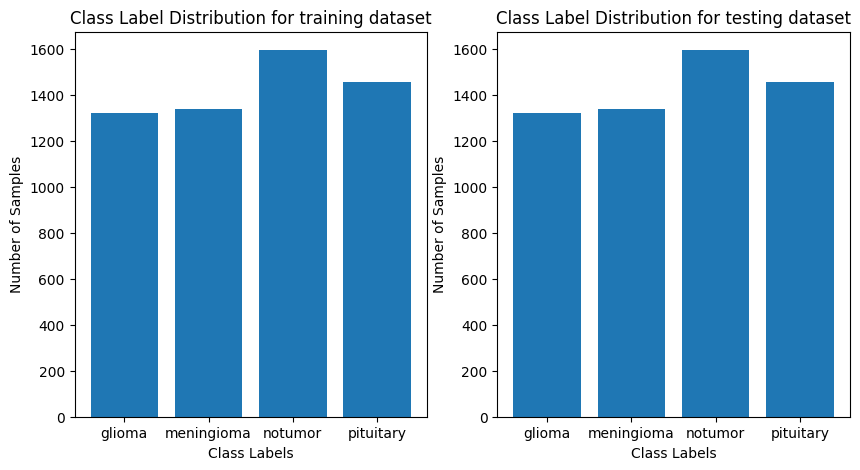

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
plot_class_dist(ax1, train_data, "training")
plot_class_dist(ax2, train_data, "testing")

In [7]:
X_train, y_train, X_val, y_val = train_val_split(train_data)
X_test, y_test = test_splits(test_data)

Number of batches in the training data: 179
Batch size of a single batch 32
Number of samples in the training dataset 5712

Number of training data batches with val split of 0.2: 144
Number of validation data batches: 35

Shape of image training set: (4608, 30, 30, 1)
Shape of image validation set: (1104, 30, 30, 1)

Shape of label training set: (4608, 4)
Shape of label validation set: (1104, 4)
Number of batches in the test data: 41
Batch size of a single batch 32
Number of samples in the test dataset 1311

Shape of image test set: (1311, 30, 30, 1)

Shape of label test set: (1311, 4)


In [8]:
cnn = cnn300k()

In [9]:
early_stopping = callbacks.EarlyStopping(monitor= 'val_loss', patience = 3, start_from_epoch= 10, restore_best_weights= True)
cnnhist = cnn.fit(X_train, y_train, batch_size =8, epochs = 50, validation_data = (X_val, y_val), verbose = 1, callbacks= early_stopping)


Epoch 1/50


I0000 00:00:1727525218.517340   43886 service.cc:146] XLA service 0x7f298c019e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727525218.517415   43886 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6


 15/576 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - F1Score: 0.1998 - accuracy: 0.2247 - loss: 1.9575 - precision: 0.3234 - recall: 0.2150

I0000 00:00:1727525223.938662   43886 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


576/576 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - F1Score: 0.4441 - accuracy: 0.4526 - loss: 1.2981 - precision: 0.6237 - recall: 0.3880 - val_F1Score: 0.4444 - val_accuracy: 0.5172 - val_loss: 1.1577 - val_precision: 0.9808 - val_recall: 0.1614
Epoch 2/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - F1Score: 0.6007 - accuracy: 0.6187 - loss: 0.9322 - precision: 0.8002 - recall: 0.6223 - val_F1Score: 0.6950 - val_accuracy: 0.7065 - val_loss: 0.7399 - val_precision: 0.9275 - val_recall: 0.6076
Epoch 3/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - F1Score: 0.6961 - accuracy: 0.7098 - loss: 0.7295 - precision: 0.8506 - recall: 0.7635 - val_F1Score: 0.5330 - val_accuracy: 0.5670 - val_loss: 1.2085 - val_precision: 0.5442 - val_recall: 0.9747
Epoch 4/50
576/576 ━━━━━━━━━━━━━━━━━━━━ -0s -611us/step - F1Score: 0.7287 - accuracy: 0.7424 - loss: 0.6895 - precision: 0.8731 - recall: 0.8114 - val_F1Score: 0.7592 - val_accuracy: 0.7772 - val_loss: 0.5519 - val_precision: 0.8997 - val_recall: 0.8797
Epoch 

In [15]:
rn = resnet()

In [17]:
rnhist = rn.fit(X_train, y_train, batch_size =64, epochs = 50, validation_data = (X_val, y_val), verbose = 1, callbacks= early_stopping)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 208ms/step - F1Score: 0.2637 - accuracy: 0.3831 - loss: 1.2322 - precision: 0.8490 - recall: 0.4380 - val_F1Score: 0.1359 - val_accuracy: 0.2681 - val_loss: 1.3867 - val_precision: 1.0000 - val_recall: 0.0380
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 164ms/step - F1Score: 0.1871 - accuracy: 0.3043 - loss: 1.3403 - precision: 0.7643 - recall: 0.1950 - val_F1Score: 0.2979 - val_accuracy: 0.4384 - val_loss: 1.1595 - val_precision: 0.8750 - val_recall: 0.6203
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 207ms/step - F1Score: 0.2580 - accuracy: 0.3689 - loss: 1.2299 - precision: 0.8793 - recall: 0.4718 - val_F1Score: 0.2815 - val_accuracy: 0.3967 - val_loss: 1.2275 - val_precision: 0.9627 - val_recall: 0.4082
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 165ms/step - F1Score: 0.2685 - accuracy: 0.3852 - loss: 1.2260 - precision: 0.8892 - recall: 0.4708 - val_F1Score: 0.3116 - val_accuracy: 0.4402 - val_loss: 1.1644 - val_precision: 0.9486 - val_recall: 0.5

In [18]:
vgg = vgg16()
vgghist = vgg.fit(X_train, y_train, batch_size =16, epochs = 50, validation_data = (X_val, y_val), verbose = 1, callbacks= early_stopping)

Epoch 1/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 33s 87ms/step - F1Score: 0.4516 - accuracy: 0.4594 - loss: 2.1800 - precision: 0.7875 - recall: 0.4693 - val_F1Score: 0.5800 - val_accuracy: 0.5897 - val_loss: 1.1473 - val_precision: 0.9586 - val_recall: 0.5127
Epoch 2/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 24s 83ms/step - F1Score: 0.6188 - accuracy: 0.6277 - loss: 1.0997 - precision: 0.8566 - recall: 0.6687 - val_F1Score: 0.4663 - val_accuracy: 0.5389 - val_loss: 1.1900 - val_precision: 0.7232 - val_recall: 0.8101
Epoch 3/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 24s 84ms/step - F1Score: 0.6269 - accuracy: 0.6436 - loss: 1.0249 - precision: 0.8700 - recall: 0.6932 - val_F1Score: 0.5605 - val_accuracy: 0.5942 - val_loss: 1.1428 - val_precision: 0.5979 - val_recall: 0.9082
Epoch 4/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 24s 84ms/step - F1Score: 0.6322 - accuracy: 0.6463 - loss: 1.0373 - precision: 0.8224 - recall: 0.7187 - val_F1Score: 0.5945 - val_accuracy: 0.6069 - val_loss: 1.1114 - val_precision: 0.9684 - val_recall:

In [19]:
dn = densenet()
dnhist = dn.fit(X_train, y_train, batch_size =64, epochs = 50, validation_data = (X_val, y_val), verbose = 1, callbacks= early_stopping)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - F1Score: 0.4644 - accuracy: 0.4724 - loss: 3.6913 - precision: 0.7338 - recall: 0.5660

W0000 00:00:1727526149.670481   43888 assert_op.cc:38] Ignoring Assert operator sequential_4_1/lambda_7_1/grayscale_to_rgb/assert_equal_1/Assert/Assert
W0000 00:00:1727526149.672117   43888 assert_op.cc:38] Ignoring Assert operator sequential_4_1/lambda_7_1/grayscale_to_rgb/assert_greater_equal/Assert/Assert
W0000 00:00:1727526155.796283   43888 assert_op.cc:38] Ignoring Assert operator sequential_4_1/lambda_7_1/grayscale_to_rgb/assert_equal_1/Assert/Assert
W0000 00:00:1727526155.796410   43888 assert_op.cc:38] Ignoring Assert operator sequential_4_1/lambda_7_1/grayscale_to_rgb/assert_greater_equal/Assert/Assert


72/72 ━━━━━━━━━━━━━━━━━━━━ 67s 474ms/step - F1Score: 0.4658 - accuracy: 0.4738 - loss: 3.6683 - precision: 0.7342 - recall: 0.5670 - val_F1Score: 0.5581 - val_accuracy: 0.5969 - val_loss: 1.2539 - val_precision: 0.9219 - val_recall: 0.5601
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - F1Score: 0.7348 - accuracy: 0.7451 - loss: 0.6631 - precision: 0.8878 - recall: 0.7928 - val_F1Score: 0.6685 - val_accuracy: 0.6730 - val_loss: 0.8454 - val_precision: 0.8782 - val_recall: 0.7532
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 184ms/step - F1Score: 0.8152 - accuracy: 0.8233 - loss: 0.4778 - precision: 0.9365 - recall: 0.8768 - val_F1Score: 0.6869 - val_accuracy: 0.6911 - val_loss: 0.8914 - val_precision: 0.8251 - val_recall: 0.7911
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - F1Score: 0.8689 - accuracy: 0.8722 - loss: 0.3328 - precision: 0.9466 - recall: 0.9085 - val_F1Score: 0.6445 - val_accuracy: 0.6576 - val_loss: 1.0122 - val_precision: 0.9559 - val_recall: 0.6171
Epoch 5

In [57]:
models = [cnn, rn, dn, base]
metrics, f1 = get_metrics(models, X_test, y_test, class_names_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - F1Score: 0.5133 - accuracy: 0.8002 - loss: 0.5314 - precision: 0.4709 - recall: 0.5072
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - F1Score: 0.0722 - accuracy: 0.0799 - loss: 1.3428 - precision: 0.4467 - recall: 0.0915
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - F1Score: 0.4222 - accuracy: 0.6597 - loss: 1.2247 - precision: 0.3774 - recall: 0.4509
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - F1Score: 0.4649 - accuracy: 0.7138 - loss: 0.7024 - precision: 0.7266 - recall: 0.6895


In [58]:
metrics = metrics.rename(columns = {0: "CNN300k", 1: "Resnet", 2: "Densenet", 3: "Baseline model"})
f1 = f1.rename(columns = {0: "CNN300k F1", 1: "Resnet F1", 2: "Densenet F1", 3: "Baseline model F1"})
display(metrics)
display(f1)

,CNN300k,Resnet,Densenet,Baseline model
accuracy,0.818459,0.314264,0.697941,0.765065
precision,0.918987,0.898734,0.775744,0.783279
recall,0.896296,0.175309,0.837037,0.736079


,CNN300k F1,Resnet F1,Densenet F1,Baseline model F1
glioma,0.775316,0.000000,0.688000,0.724437
meningioma,0.667802,0.000000,0.463551,0.588430
notumor,0.911581,0.425612,0.802817,0.865429
pituitary,0.886667,0.402694,0.767213,0.840830


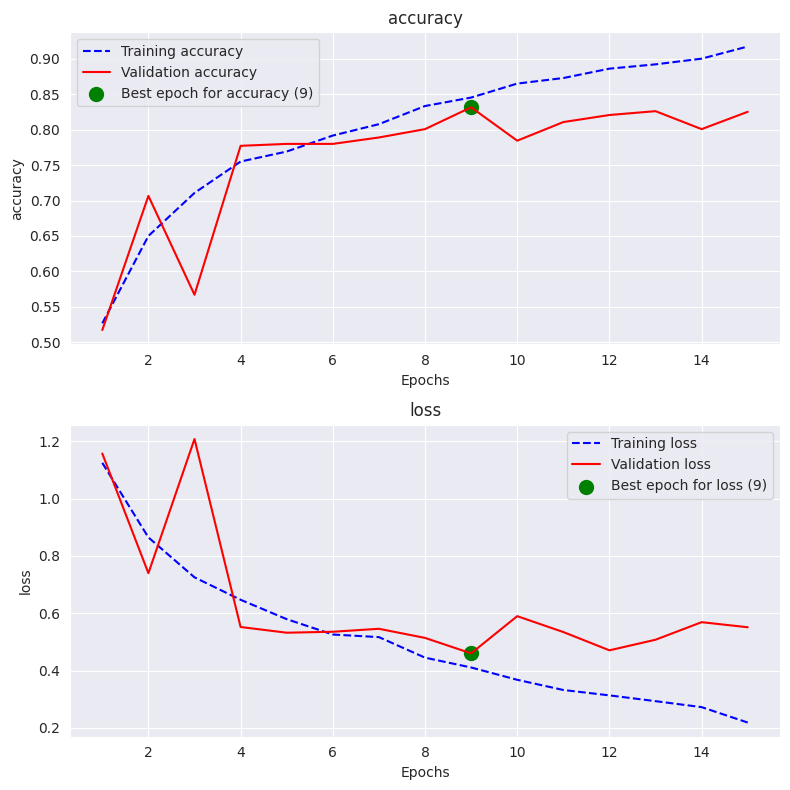

In [36]:
summarize_metric(cnnhist)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


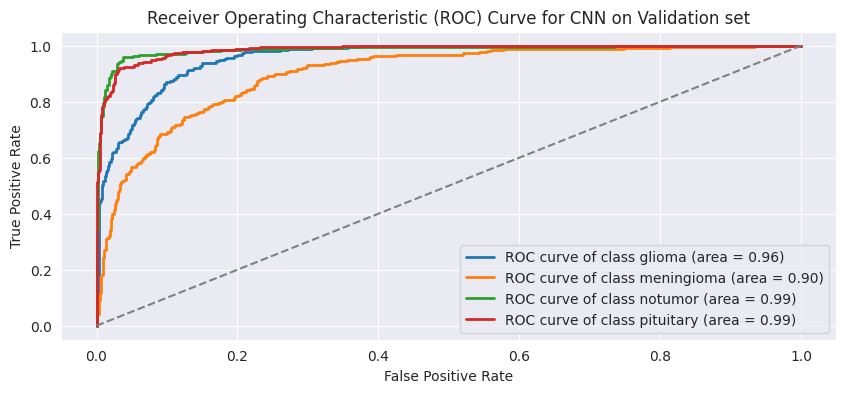

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


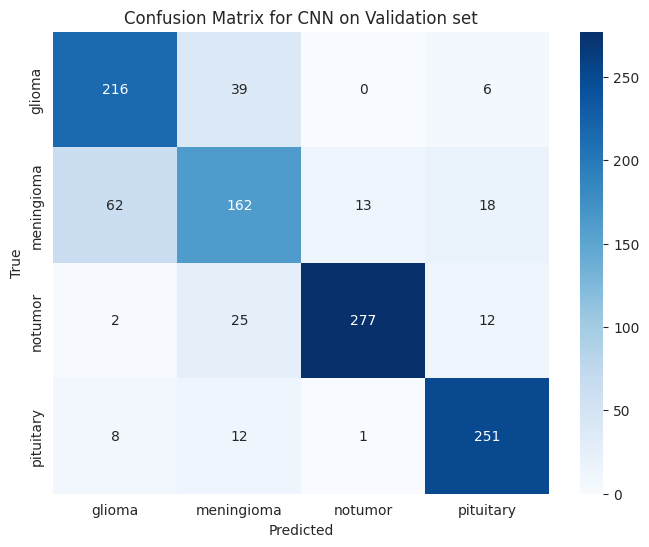

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


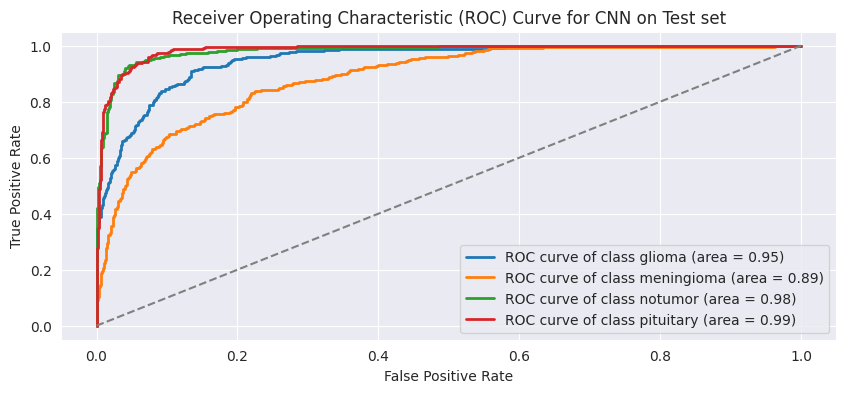

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


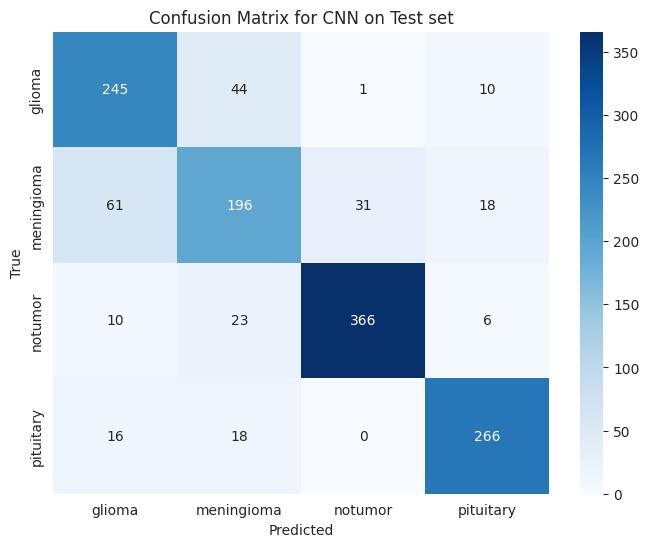

In [46]:
plot_roc_curve(cnn, X_val, y_val, class_names_train, title = 'CNN on Validation set')
plot_confusion_matrix(cnn, X_val, y_val, class_names_train, normalize=False, title = 'CNN on Validation set')

plot_roc_curve(cnn, X_test, y_test, class_names_test, title = 'CNN on Test set')
plot_confusion_matrix(cnn, X_test, y_test, class_names_test, normalize=False, title = 'CNN on Test set')


# Baseline Model

In [38]:
base = baseline()
history = base.fit(X_train, y_train, batch_size =32, epochs = 10, validation_data = (X_val, y_val))

Epoch 1/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - F1Score: 0.3580 - accuracy: 0.4259 - loss: 1.1950 - precision: 0.8013 - recall: 0.1321 - val_F1Score: 0.6575 - val_accuracy: 0.6567 - val_loss: 0.8500 - val_precision: 0.7509 - val_recall: 0.5489
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - F1Score: 0.7041 - accuracy: 0.7168 - loss: 0.7610 - precision: 0.7791 - recall: 0.6037 - val_F1Score: 0.6898 - val_accuracy: 0.7083 - val_loss: 0.7302 - val_precision: 0.7714 - val_recall: 0.6295
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - F1Score: 0.7329 - accuracy: 0.7424 - loss: 0.6752 - precision: 0.7974 - recall: 0.6805 - val_F1Score: 0.7174 - val_accuracy: 0.7355 - val_loss: 0.6962 - val_precision: 0.7867 - val_recall: 0.6549
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - F1Score: 0.7603 - accuracy: 0.7709 - loss: 0.6100 - precision: 0.8170 - recall: 0.7133 - val_F1Score: 0.7451 - val_accuracy: 0.7509 - val_loss: 0.6794 - val_precision: 0.7896 - val_recall: 0.7002

In [ ]:
summarize_metric(history)

plot_roc_curve(base, X_val, y_val, class_names_train, title = 'Validation set')
plot_confusion_matrix(base, X_val, y_val, class_names_train, normalize=False, title = 'Validation set')

plot_roc_curve(base, X_test, y_test, class_names_test, title = 'Test set')
plot_confusion_matrix(base, X_test, y_test, class_names_test, normalize=False, title = 'Test set')

In [40]:
models = [base, cnn]

metrics, f1 = get_metrics(models, X_test, y_test, class_names_test)
display(metrics.rename(columns = {0: "Baselinemodel", 1: "CNN300k"}))
display(f1.rename(columns = {0: "Baselinemodel F1", 1: "CNN300k F1"}))

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - F1Score: 0.4649 - accuracy: 0.7138 - loss: 0.7024 - precision: 0.7266 - recall: 0.6895
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - F1Score: 0.5133 - accuracy: 0.8002 - loss: 0.5314 - precision: 0.4709 - recall: 0.5072       


,Baselinemodel,CNN300k
accuracy,0.765065,0.818459
precision,0.783279,0.918987
recall,0.736079,0.896296


,Baselinemodel F1,CNN300k F1
glioma,0.724437,0.775316
meningioma,0.588430,0.667802
notumor,0.865429,0.911581
pituitary,0.840830,0.886667
